# Assignment 4 - Grover's Search Algorithm 

In this assignment we are going to explore Grover's search algorithm, one of the most famous quantum algorithms. Grover's algorithm is an algorithm for solving the following search problem. Given a function $f$ which take and N-bit input and returns a 1-bit output, 0 or 1, find any input $x_0$ for which $f(x_0) = 1$.

We can represent this problem on a quantum computer by defining an oracle, G, which acts on our state as follows:
$$
G|\psi\rangle =  \begin{cases} 
      -|x\rangle & |x\rangle = \text{a state for which }f(x) = 1\\
       |x\rangle & \text{otherwise}
   \end{cases}\\
$$

Grover's algorithm allows us to find a value $x$ for which $f(x) = 1$ with only $O(\sqrt{\frac{2^N}{k}})$ applications of G, where $k$ is the number of $x$'s for which $f(x) = 1$.  

#### Run these cells before beginning to import necessary packages.
This cell may take a minute or more to complete. Importing qsharp triggers a sequence of actions which allow us to compile and run Q# code in this notebook.

In [1]:
import qsharp
from qsharp import azure
import matplotlib.pyplot as plt

Preparing Q# environment...


In [2]:
%%qsharp 
open Microsoft.Quantum.Diagnostics; 
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Random;

## <span style="color:#61c2e8">Task 1 Finding Alternating Bit Strings Using Grover's Search</span>:
First we will define an oracle. In order to define an oracle we only need to know how to implement the function $f$. Grover's algorithm is suitable for problems in which defining $f$ is easy, while finding a value $x$ which satisfies the equation $f(x) = 1$ is not. One example would be a Sudoku puzzle, where it is easier to check whether a grid filled with digits is an answer than it is to find the answer.

For this example we will consider the function $f(x)$ which is equal to 1 when $x$ is a bit string of length $N$ in which no pair of adjacent bits have the same value. If you think about this, it becomes clear that the bit strings for which $f(x) = 1$ alternate between 0 and 1. This means that for any N there will be two possible solutions, one starting with 0 and one starting with 1. So for this example $k = 2$.

So our $f$ will look like this:
$$
f(x) =  \begin{cases} 
      1 & x = 0101\text{... or }1010\text{...}\\
      0 & \text{otherwise}
   \end{cases}\\
$$
However, our oracle will not mark these two states explicitly based on our ability to find the solution classically. Instead, it will use binary logic to check the condition by verifying that each pair of adjacent bits has different values. In this way we can build our oracle without actually knowing what the target states will be.

In [6]:
%%qsharp
/// # Summary
/// A phase oracle which applies a negative phase to 
/// the states where no adjacent bits are equal.
///
/// # Input 
/// ## qs 
/// The qubits which are having the oracle applied to them. 

operation AlternatingBitStringOracle(qs : Qubit[]) : Unit { 
    // We first apply a CNOT gate between each pair of adjacent qubits
    // to calculate qs[i] XOR qs[i-1] and store the result in qs[i-1].
    // Next, we apply a CZ to the output of all of these XOR operations
    // flipping the phase of the state where each XOR evaluates to 1.
    // Then we uncompute the previous CNOT gates to return the phase
    // to the target states. 

    // The within-apply statement does 3 things:
    // 1. Performs the operations in the within block.
    // 2. Performs the operations in the apply block.
    // 3. Calculates and performs the adjoint of the within block.
    within {
        for i in 1 .. Length(qs) - 1 {
            CNOT(qs[i], qs[i-1]);
        }
    } apply {
        Controlled Z(qs[0 .. Length(qs) - 3], qs[Length(qs) - 2]);
    }
}

Next, we need to define Grover's diffusion operator. A lot has been written about the reasoning behind the diffusion operator; [this article](https://cnot.io/quantum_algorithms/grover/grovers_algorithm.html) does a great job of explaining it.



In [7]:
%%qsharp
/// # Summary
/// Grover's diffusion operator
///
/// # Input
/// ## qs
/// The qubit array which the diffusion operator is applied to.

operation Diffusion(qs : Qubit[]) : Unit {
    within {
        ApplyToEachA(H, qs);
        ApplyToEachA(X, qs);
    } apply {
        // Most gives us every array element except the last.
        // Tail gives us the last array element.
        Controlled Z(Most(qs), Tail(qs));
    }
}

Lastly, let us define our top-level operation. In it we will allocate the qubits we will use, apply the operations `AlternatingBitStringOracle` and `Diffusion` a specified number of times, and measure the qubits to read out the solution. Note that instead of calculating the optimal number of iterations during runtime we set things up so we can control the number when calling the operation.

In [8]:
%%qsharp
/// # Summary
/// The top-level operation for this implementation. 
/// Applies the oracle and diffusion operator multiple times.
///
/// # Input
/// ## iterations
/// The number of times to apply the oracle and diffusion operator.
/// ## N 
/// The number of qubits to use. Our search space size is then 2^N.
///
/// # Output
/// A Result[] type which contains the measurement result of each
/// qubit that was allocated. 

operation Grovers(iterations : Int, N : Int) : Result[] {
    use qs = Qubit[N];
    ApplyToEach(H, qs);

    for i in 1 .. iterations {
        AlternatingBitStringOracle(qs);
        Diffusion(qs);
    }
    return ForEach(M, qs);
}

Now you can run this cell to see whether our measurement produced a state that is a solution to our problem. 

In [9]:
Grovers.simulate(iterations=35, N = 12)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Run this to see how many times a query returns a correct answer. Starting with N = 4 and iterations = 2.

In [9]:
# Vary these values for question #2
N = 4
iterations = 2 

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


96.0% of queries returned a correct answer


Even on an ideal simulation we are only finding a target $x$ ~94% of the time. Fortunately this relatively large error rate decrease significantly as we increase N. As we increase N the probability of measuring the target after the optimal number of iterations will approach 1. 


However, on hardware we can expect this to be quite a bit worse, especially as we increase the size of the search space and the number of iterations (which translate to the number of qubits and the circuit depth, respectively). Let us submit this job to hardware and see how things play out.

Connect to Azure workspace.

In [10]:
qsharp.azure.connect(
   resourceId="/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj",
   location="East US")

Connecting to Azure Quantum...

Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace IntroToQuantumProj in location eastus.


[{'id': 'ionq.qpu', 'current_availability': {}, 'average_queue_time': 9783},
 {'id': 'ionq.qpu.aria-1', 'current_availability': {}, 'average_queue_time': 1595920},
 {'id': 'ionq.simulator', 'current_availability': {}, 'average_queue_time': 2},
 {'id': 'microsoft.estimator', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s1', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s1-apival', 'current_availability': {}, 'average_queue_time': 8},
 {'id': 'quantinuum.hqs-lt-s2', 'current_availability': {}, 'average_queue_time': 142151},
 {'id': 'quantinuum.hqs-lt-s2-apival', 'current_availability': {}, 'average_queue_time': 15},
 {'id': 'quantinuum.hqs-lt-s1-sim', 'current_availability': {}, 'average_queue_time': 80},
 {'id': 'quantinuum.hqs-lt-s2-sim', 'current_availability': {}, 'average_queue_time': 3620},
 {'id': 'quantinuum.hqs-lt', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.qpu.h1-1', 'current_

Set the target to ionq.qpu.

In [11]:
qsharp.azure.target("ionq.qpu")

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu


{'id': 'ionq.qpu', 'current_availability': {}, 'average_queue_time': 9783}

In [12]:
N = 4
iterations = 2
qsharp.azure.submit(Grovers, iterations=iterations, N=N, shots=500, jobName="Grover's iterations={}, N={}".format(iterations, N))

Submitting Grovers to target ionq.qpu...
Job successfully submitted.
   Job name: Grover's iterations=2, N=4
   Job ID: 439fe676-ac2c-4a6c-b9dc-ad5e724f9a0b


{'id': '439fe676-ac2c-4a6c-b9dc-ad5e724f9a0b', 'name': "Grover's iterations=2, N=4", 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=439fe676-ac2c-4a6c-b9dc-ad5e724f9a0b', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-12-08T06:22:58.2058849+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [15]:
qsharp.azure.status()

{'id': '439fe676-ac2c-4a6c-b9dc-ad5e724f9a0b', 'name': "Grover's iterations=2, N=4", 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=439fe676-ac2c-4a6c-b9dc-ad5e724f9a0b', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-12-08T06:22:58.2058849+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [16]:
output = qsharp.azure.output(jobId="a9b95693-43c9-4442-afc4-d6f4c5e37669")

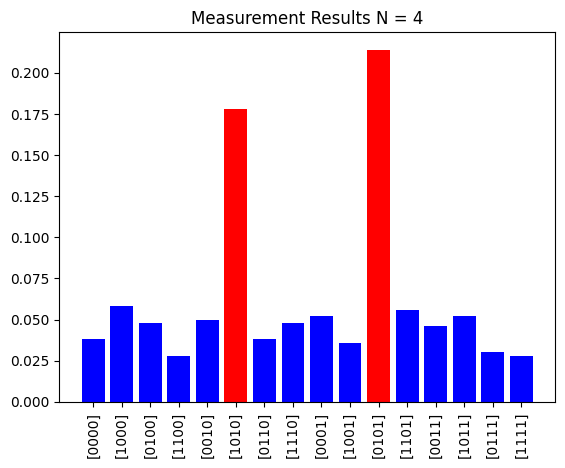

In [17]:
keys = list(output.keys())
keys = [key.replace(",", "") for key in keys]
keyLen = len(keys[0]) - 2
firstBitString = ""
secondBitString = ""
for i in range(keyLen):
    firstBitString += str((i+1)%2)
    secondBitString += str(i%2)
secondBitString = "[{}]".format(secondBitString)
firstBitString = "[{}]".format(firstBitString)
outputFreq = list(output.values())

firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
plt.xticks(rotation=90)
plt.title("Measurement Results N = {}".format(keyLen))
plt.show()

### <span style="color:#61c2e8">Task 1 Questions</span>:

* T1.1. Calculate the optimal number of iterations for N = 2, 3, 4, 5, 7 and 12. Please round your answer down.

* T1.2. Run the noiseless simulation code with these values of N and the number of iterations you calculated. For each N, what is the approximate percentage of runs that produced correct answers? What are you noticing about the behavior of this value as N increases?

* T1.3. The N=2 case doesn't perform any better than just randomly sampling the search space. Provide a possible explanation for this.

* T1.4. What happens when you do more iterations than the optimal number of iterations? Compare this to doing fewer than the optimal number of iterations. Use the noiseless simulation code to experiment. 

* T1.5. Submit a job to the IonQ QPU for N = 3, 4 and 5 using the number of iterations you calculated. What are you seeing as N increases?

> `qsharp.azure.output` defaults to the last submitted job. We recommend submitting all hardware jobs as soon as you can, since it can take a while for them to finish. You can then get the output for each of them by calling `qsharp.azure.output(jobId="job id")`. The job ids can be found in your Azure Quantum Workspace in Operations $\rightarrow$ Job Management.


##### T 1.1

The formula to calculate the optimal number of iterations for any N for the Grover search algorithm is shown below
$$
    N_\text{optimal} = \lfloor \frac{\pi}{4} \sqrt{\frac{2^N}{K}} - \frac{1}{2} \rfloor
$$
In the above equation $2^n$ [eligible items for the search task](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers) and *K* repreesents [the different valid inputs](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers).

The following code segment computed the optimal number of iterations for *N*$=2, 3, 4, 5, 7, \text{and } 12$.

[The above discussion referenced this link.](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers)

In [1]:
import numpy as np

N        = np.array([2, 3, 4, 5, 7, 12])
K        = 2
num_iter = np.floor((np.pi/4) * np.sqrt((2**N)/K) - (1/2))

print(num_iter)

[ 0.  1.  1.  2.  5. 35.]


As seen by the code segment above, the optimal number of iterations for *N*$=2,3,4,5,7,\text{and }, 12$ is $[ 0, 1, 1, 2, 5, 35 ]$, respectively.

##### T 1.2

The code segments below runs the simulations with *N*$=2,3,4,5,7,\text{and }12$ and the number of iterations set to their respective optimal value computed above. The code segments below also display the approximate percentage of runs that produced the correct answers. The results are shown below.

In [47]:
N = 2
iterations = 0

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


54.0% of queries returned a correct answer


In [37]:
N = 3
iterations = 1

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


100.0% of queries returned a correct answer


In [39]:
N = 4
iterations = 1

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


73.0% of queries returned a correct answer


In [48]:
N = 5
iterations = 2

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


90.0% of queries returned a correct answer


In [49]:
N = 7
iterations = 5

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


96.0% of queries returned a correct answer


In [50]:
N = 12
iterations = 35

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))


100.0% of queries returned a correct answer


The code segments above display the approximate percentage of runs that produced the answers. Approsimately, when *N*$=2$ the approximatley $50\%$ of runs produced the correct answers, when *N*$=3$ the approximatley all runs produced the correct answer, when *N*$=4$ the approximatley $75\%$ of runs produced the correct answer, when *N*$=7$ the approximatley $95\%$ of runs produced the correct answer, and when *N*$=12$ the approximatley all runs produced the correct answer. As the value of *N* increased, the optimal number of iterations produced a higher percentage of correct answers.

##### T 1.3

When *N*$=2$ and *K*$=2$, the Grover search algorithm does not perform any better than randomly searching the search space, because when the eligible items for the search task matches the number of valid inputs. Because the cardinality of the search space is small, i.e. $2$, randomly searching and performing the Grover's search algorithm with an optimal number of iterations of $1$ would result in the same output.

##### T 1.4

The two code segments below show the result of performing more number of iterations than the optimal number of iterations when *N*$=2$ and the result of performing fewer number of iterations than the optimal number of iterations when *N*$=2$, respectively.

In [51]:
N = 12
iterations = 17

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))

51.0% of queries returned a correct answer


In [52]:
N = 12
iterations = 70

target1 = [i%2 for i in range(N)]
target2 = [i%2 for i in range(1, N+1)]
shots = 100
correctCount = 0
for shot in range(shots):
    result = Grovers.simulate(iterations=iterations, N=N)
    if result == target1 or result == target2:
        correctCount += 1
print("{}% of queries returned a correct answer".format(100 * correctCount/shots))

0.0% of queries returned a correct answer


As seen by the two code segments above, if we were to perform more number of iterations than the optimal number of iterations or if we were to perform fewer number of iterations than the optimal number of iterations the percentage of runs that find the correct answer decreases. Therefore, when performing Grover's search we should always use the optimal number of iterations, not more or less.

##### T 1.5

The following code segments submit a job to the IonQ QPU for *N*$=2,3,\text{and }5$ using the optimal number of iterations for these values of *N*, calculated above. 

In [4]:
qsharp.azure.connect(
   resourceId="/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj",
   location="East US")

qsharp.azure.target("ionq.qpu")

Connecting to Azure Quantum...

Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace IntroToQuantumProj in location eastus.
Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu


{'id': 'ionq.qpu', 'current_availability': {}, 'average_queue_time': 51722}

In [13]:
N = 3
iterations = 1
qsharp.azure.submit(Grovers, iterations=iterations, N=N, shots=500, jobName="Grover's iterations={}, N={}".format(iterations, N))

qsharp.azure.status()

Submitting Grovers to target ionq.qpu...
Job successfully submitted.
   Job name: Grover's iterations=1, N=3
   Job ID: 9f563f62-da98-435e-b909-52e7a0f22d56


{'id': '9f563f62-da98-435e-b909-52e7a0f22d56', 'name': "Grover's iterations=1, N=3", 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=9f563f62-da98-435e-b909-52e7a0f22d56', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-12-09T00:35:04.7374128+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [5]:
output = qsharp.azure.output(jobId="9f563f62-da98-435e-b909-52e7a0f22d56")

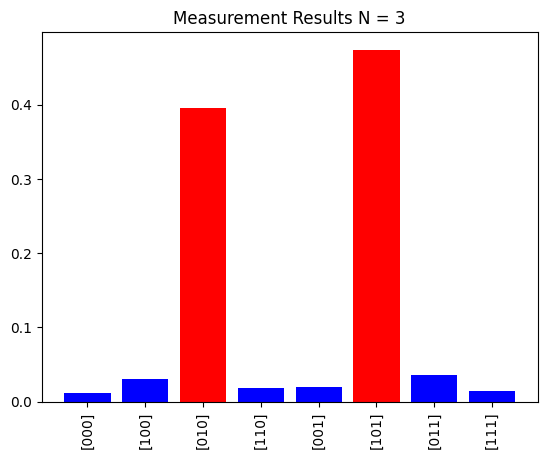

In [6]:
keys = list(output.keys())
keys = [key.replace(",", "") for key in keys]
keyLen = len(keys[0]) - 2
firstBitString = ""
secondBitString = ""
for i in range(keyLen):
    firstBitString += str((i+1)%2)
    secondBitString += str(i%2)
secondBitString = "[{}]".format(secondBitString)
firstBitString = "[{}]".format(firstBitString)
outputFreq = list(output.values())

firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
plt.xticks(rotation=90)
plt.title("Measurement Results N = {}".format(keyLen))
plt.show()

In [16]:
N = 4
iterations = 1
qsharp.azure.submit(Grovers, iterations=iterations, N=N, shots=500, jobName="Grover's iterations={}, N={}".format(iterations, N))

qsharp.azure.status()

Submitting Grovers to target ionq.qpu...
Job successfully submitted.
   Job name: Grover's iterations=1, N=4
   Job ID: 41fba03b-18c6-48a6-b0ab-e37e3d5fd80e


{'id': '41fba03b-18c6-48a6-b0ab-e37e3d5fd80e', 'name': "Grover's iterations=1, N=4", 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=41fba03b-18c6-48a6-b0ab-e37e3d5fd80e', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-12-09T00:38:14.6876557+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [8]:
output = qsharp.azure.output(jobId="41fba03b-18c6-48a6-b0ab-e37e3d5fd80e")

Submitting Grovers to target ionq.qpu...
Job successfully submitted.
   Job name: Grover's iterations=1, N=4
   Job ID: 589c85a6-671d-4dbe-bb16-43afa5e5616b


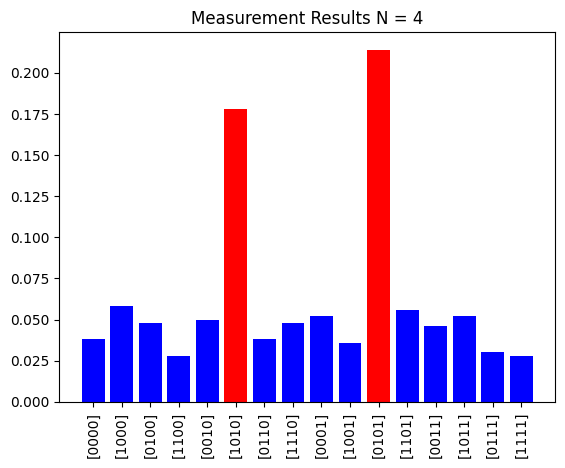

In [58]:
keys = list(output.keys())
keys = [key.replace(",", "") for key in keys]
keyLen = len(keys[0]) - 2
firstBitString = ""
secondBitString = ""
for i in range(keyLen):
    firstBitString += str((i+1)%2)
    secondBitString += str(i%2)
secondBitString = "[{}]".format(secondBitString)
firstBitString = "[{}]".format(firstBitString)
outputFreq = list(output.values())

firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
plt.xticks(rotation=90)
plt.title("Measurement Results N = {}".format(keyLen))
plt.show()

In [18]:
N = 5
iterations = 2
qsharp.azure.submit(Grovers, iterations=iterations, N=N, shots=500, jobName="Grover's iterations={}, N={}".format(iterations, N))

qsharp.azure.status()

Submitting Grovers to target ionq.qpu...
Job successfully submitted.
   Job name: Grover's iterations=2, N=5
   Job ID: 5525e510-aec8-4c51-a807-1bad1f31c8b3


{'id': '5525e510-aec8-4c51-a807-1bad1f31c8b3', 'name': "Grover's iterations=2, N=5", 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=5525e510-aec8-4c51-a807-1bad1f31c8b3', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-12-09T00:39:32.2149156+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [9]:
output = qsharp.azure.output(jobId="5525e510-aec8-4c51-a807-1bad1f31c8b3")

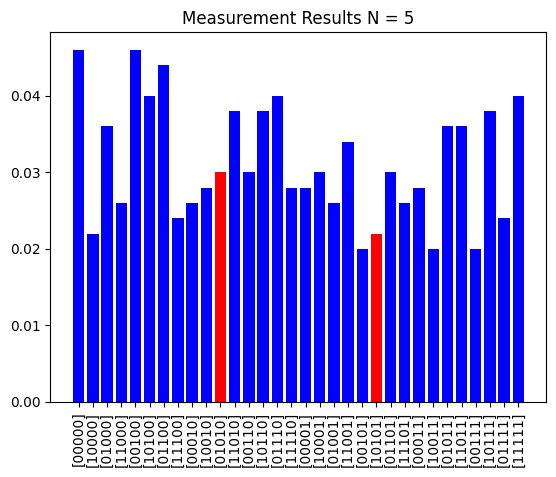

In [10]:
keys = list(output.keys())
keys = [key.replace(",", "") for key in keys]
keyLen = len(keys[0]) - 2
firstBitString = ""
secondBitString = ""
for i in range(keyLen):
    firstBitString += str((i+1)%2)
    secondBitString += str(i%2)
secondBitString = "[{}]".format(secondBitString)
firstBitString = "[{}]".format(firstBitString)
outputFreq = list(output.values())

firstBitStringLoc = min(keys.index(firstBitString), keys.index(secondBitString))
secondBitStringLoc = max(keys.index(firstBitString), keys.index(secondBitString))

plt.bar(keys[0:firstBitStringLoc], outputFreq[0:firstBitStringLoc], color = "blue")
plt.bar(keys[firstBitStringLoc], outputFreq[firstBitStringLoc], color = "red")
plt.bar(keys[firstBitStringLoc+1:secondBitStringLoc], outputFreq[firstBitStringLoc+1:secondBitStringLoc], color = "blue")
plt.bar(keys[secondBitStringLoc], outputFreq[secondBitStringLoc], color = "red")
plt.bar(keys[secondBitStringLoc+1:], outputFreq[secondBitStringLoc+1:], color = "blue")
plt.xticks(rotation=90)
plt.title("Measurement Results N = {}".format(keyLen))
plt.show()

The results shown above display the output of submitting the Grover's search algorithm job to the IonQ QPU for *N*$=3, 4, \text{and } 5$. As the number *N* increases, the probability of finding the target decreases because we have increased the search space - and the number of iterations correspondingly. 